# **Implementing the Lasso Regression Methodology to the study by Nathan Nunn (2008)**

### **IV Group Members:**
* Colon, Christopher
* Rodriguez Quinto, Anel
* Stevens, Madison
* Stutts, Charlie
* Xu, Davis

**The article can be found here:** https://www.jstor.org/stable/25098896

**The dataset of the paper can be found here:** https://nathannunn.arts.ubc.ca/data/

**The Google Colab project can be found here:** https://colab.research.google.com/drive/19Rc1VzFgVn_KXGHygORPp26AeBBzToUl#scrollTo=KIyK8PmmytZ8

### **Step 1: Data Preprocessing** ###

Here we read the data in and perform preprocessing steps to make the data usable for the Lasso selection method. These preprocessing steps include dropping irrelevent vaariables and normalizing the data.

In [195]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from statsmodels.sandbox.regression.gmm import IV2SLS
import numpy as np
import statsmodels.api as sm
from scipy.stats import pearsonr

#!git clone https://github.com/ECMT-680-Financial-Econometrics/IV-Group-Slave-Trade.git

# Navigate to the repository directory
#%cd IV-Group-Slave-Trade

data = pd.read_csv('slave_trade_QJE_New_Data.csv')
# Preprocessing the data
data = data.drop(data.columns[[0,1]], axis=1) #Drop the first two columns

# Drop the columns that are not needed
columnstodrop = ['atlantic_distance_minimum_region_n_interaction', 'atlantic_distance_minimum_region_s_interaction', 'atlantic_distance_minimum_region_w_interaction', 'atlantic_distance_minimum_region_e_interaction', 'atlantic_distance_minimum_region_c_interaction', 'indian_distance_minimum_region_n_interaction', 'indian_distance_minimum_region_s_interaction', 'indian_distance_minimum_region_w_interaction', 'indian_distance_minimum_region_e_interaction', 'indian_distance_minimum_region_c_interaction', 'saharan_distance_minimum_region_n_interaction', 'saharan_distance_minimum_region_s_interaction', 'saharan_distance_minimum_region_w_interaction', 'saharan_distance_minimum_region_e_interaction', 'saharan_distance_minimum_region_c_interaction', 'red_sea_distance_minimum_region_n_interaction', 'red_sea_distance_minimum_region_s_interaction', 'red_sea_distance_minimum_region_w_interaction', 'red_sea_distance_minimum_region_e_interaction', 'red_sea_distance_minimum_region_c_interaction'] #Drop the first two columns
data = data.drop(columnstodrop, axis=1) 

# Preprocess the data
data = data.apply(pd.to_numeric, errors='coerce') #Convert all columns to numeric

# Scale non-binary columns for normalization
cols_to_scale = data.apply(lambda x: not pd.Series([0, 25]).isin(x).all())
data.loc[:, cols_to_scale] = scale(data.loc[:, cols_to_scale])

data = data.apply(lambda x: x.fillna(x.median()), axis=0)


### **Step 2: Select variables using the Lasso selection method** ###
First, we perform the Lasso between the dependent variable and the exogenous variables to select the most relevent variables for the regression. Then we perform the Lasso between the endogeneous and exogenous variables to determine the most relevant variables for predicting the endogenous variable. 

The unique variables from both Lassos are then combined into a final list of variables for the regression.

In [199]:
# Define the dependent variable and instrumental variable
dependent_var = "gdp00"
endogeneous_var = "ln_export_area"

# Separate the covariates and the dependent variable
X = data.drop(data.columns[0:25], axis=1)
y = data[dependent_var]
Z = data[endogeneous_var]


# Perform Lasso to select important variables
lasso_y = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X, y)
selected_y = X.columns[lasso_y.coef_ != 0]
print(selected_y)

lasso_z = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X.drop(columns=Z.name), Z)
selected_z = X.drop(columns=Z.name).columns[(lasso_z.coef_ != 0)]
print(selected_z)

# Get the indices of selected features
selected_vars = np.unique(np.concatenate([selected_y, selected_z]))
print(selected_vars)


Index(['ln_export_area', 'colony0', 'colony1', 'colony3', 'colony4', 'colony7',
       'rain_min', 'ln_coastline_area', 'region_c', 'ln_avg_oil_pop',
       'ln_avg_all_diamonds_pop', 'ln_pop_dens_1400',
       'red_sea_distance_minimum'],
      dtype='object')
Index(['ln_export_pop', 'colony1', 'colony3', 'colony6', 'colony7', 'rain_min',
       'low_temp', 'ln_coastline_area', 'island_dum', 'islam', 'region_n',
       'region_w', 'ln_avg_gold_pop', 'ln_avg_oil_pop',
       'ln_avg_all_diamonds_pop', 'ln_pop_dens_1400',
       'saharan_distance_minimum', 'ethnic_fractionalization'],
      dtype='object')
['colony0' 'colony1' 'colony3' 'colony4' 'colony6' 'colony7'
 'ethnic_fractionalization' 'islam' 'island_dum' 'ln_avg_all_diamonds_pop'
 'ln_avg_gold_pop' 'ln_avg_oil_pop' 'ln_coastline_area' 'ln_export_area'
 'ln_export_pop' 'ln_pop_dens_1400' 'low_temp' 'rain_min'
 'red_sea_distance_minimum' 'region_c' 'region_n' 'region_w'
 'saharan_distance_minimum']


### **Step 3: OLS Model with Selected Variables** ###

Here we use the selected variables to predict the outcomes for 2000 GDP. The results of this model are printed below.

In [200]:
# Create a design matrix for regression
X_selected = sm.add_constant(data[selected_vars])
# X_selected = X_selected.drop(columns=[endogeneous_var])

# Fit a final OLS model using only selected variables
ols_model = sm.OLS(y, X_selected).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  gdp00   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     6.973
Date:                Mon, 29 Apr 2024   Prob (F-statistic):           1.60e-06
Time:                        13:57:23   Log-Likelihood:                -24.223
No. Observations:                  52   AIC:                             96.45
Df Residuals:                      28   BIC:                             143.3
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### **Step 4: Perform an IV regression with the selected variables** ###
Now we perform a IV2SLS regression with the selected instruments and controls. The results of this model are printed below.

In [201]:
# Step 4: Conduct IV regression using the selected instruments and controls
iv_model = IV2SLS(y, sm.add_constant(data[Z.name]), data[selected_vars]).fit()

print(iv_model.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                  gdp00   R-squared:                       0.224
Model:                         IV2SLS   Adj. R-squared:                  0.208
Method:                     Two Stage   F-statistic:                     14.46
                        Least Squares   Prob (F-statistic):           0.000391
Date:                Mon, 29 Apr 2024                                         
Time:                        13:57:30                                         
No. Observations:                  52                                         
Df Residuals:                      50                                         
Df Model:                           1                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0226      0.194     -0.

## **Repeating the Lasso Selection process for Years 2000-2022**

### **Step 1: Selecting the features for each regression** ###

Here we iterate through each year to find select variables for their individual regresions through the process described before.

In [202]:
second_stage_variables = ['gdp00', 'gpd01', 'gdp02', 'gdp03', 'gdp04', 'gdp05', 'gdp06', 'gdp07', 'gdp08', 'gdp09', 'gdp10', 'gdp11', 'gdp12', 'gdp13', 'gdp14', 'gdp15','gdp16', 'gdp17', 'gdp18', 'gdp19', 'gdp20', 'gdp21', 'gdp22']
endogeneous_var_var = "ln_export_area"

# Separate the covariates and the dependent variable
X = data.drop(data.columns[0:25], axis=1)
y = data[second_stage_variables]
Z = data[endogeneous_var_var]
for dependent_variable in second_stage_variables:
    # Perform Lasso to select important variables
    lasso_y = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X, data[dependent_variable])
    selected_y = X.columns[lasso_y.coef_ != 0]

    lasso_z = LassoCV(cv=5, max_iter=10000, tol=0.0001, random_state=0).fit(X, Z)
    selected_z = X.columns[(lasso_z.coef_ != 0)]

    # Get the indices of selected features
    selected_vars = np.unique(np.concatenate([selected_y, selected_z]))
    print(selected_vars)
    # Create a design matrix for regression
    X_selected = data[selected_vars]

    # Perform 2SLS (Two-Stage Least Squares) using the instrumental variable
    # First stage: Regress the instrumental variable with selected features
    first_stage = sm.OLS(Z, sm.add_constant(X_selected)).fit()
    # Get predicted values from the first stage
    Z_pred = first_stage.predict(sm.add_constant(X_selected))
    
    # Second stage: Regress the dependent variable on the predicted values
    iv_model = IV2SLS(data[dependent_variable], sm.add_constant(data[Z.name]), data[selected_vars]).fit()
    
    exog_second_stage = X_selected.merge(Z_pred.rename('Z_pred'), left_index=True, right_index=True)
    second_stage_model = sm.OLS(data[dependent_variable], exog_second_stage).fit()
    


['colony0' 'colony1' 'colony3' 'colony4' 'colony7'
 'ln_avg_all_diamonds_pop' 'ln_avg_oil_pop' 'ln_coastline_area'
 'ln_export_area' 'ln_pop_dens_1400' 'rain_min' 'red_sea_distance_minimum'
 'region_c']
['colony0' 'colony1' 'colony3' 'colony4' 'colony5' 'colony7' 'islam'
 'ln_avg_all_diamonds_pop' 'ln_avg_oil_pop' 'ln_coastline_area'
 'ln_export_area' 'ln_pop_dens_1400' 'rain_min' 'red_sea_distance_minimum'
 'region_c']
['colony0' 'colony1' 'colony3' 'colony4' 'colony5' 'colony7'
 'ln_avg_all_diamonds_pop' 'ln_avg_oil_pop' 'ln_coastline_area'
 'ln_export_area' 'ln_pop_dens_1400' 'rain_min' 'red_sea_distance_minimum'
 'region_c']
['colony0' 'colony1' 'colony3' 'colony4' 'colony5' 'colony7' 'islam'
 'ln_avg_all_diamonds_pop' 'ln_avg_oil_pop' 'ln_coastline_area'
 'ln_export_area' 'ln_pop_dens_1400' 'rain_min' 'red_sea_distance_minimum'
 'region_c']
['colony0' 'colony1' 'colony3' 'colony4' 'colony5' 'colony7' 'islam'
 'ln_avg_all_diamonds_pop' 'ln_avg_oil_pop' 'ln_coastline_area'
 'ln_expo

### **Step 2: Running the regressions with the selected variables and grabbing the resulting coefficients** ###

After the variables are selected, we implement these variables into the IV2SLS model in order to estimate the coefficient of the regressions for each year. These coefficients are then stored for future plotting.

In [203]:
import pandas as pd

# Define an empty list to store the coefficients
coefficients_table = []

for dependent_variable in second_stage_variables:
    # Rest of the code remains the same as before

    # Fit the second stage regression
    iv_model = IV2SLS(data[dependent_variable], sm.add_constant(data[Z.name]), data[selected_vars]).fit()

    # Extract the coefficient of ln_export_area_predicted
    coefficient = iv_model.params['ln_export_area']
    std_err = iv_model.bse['ln_export_area']
    # Calculate the 95% confidence intervals
    lower_ci = coefficient - 1.96 * std_err
    upper_ci = coefficient + 1.96 * std_err
    # Store the coefficient along with the dependent variable name
    coefficients_table.append({'Dependent Variable': dependent_variable, 'Coefficient': coefficient, 'Lower CI': lower_ci, 'Upper CI': upper_ci})

# Create a DataFrame from the coefficients list
coefficients_df = pd.DataFrame(coefficients_table)

# Add a column representing years from 2000 to 2022
years = list(range(2000, 2023))
coefficients_df['Year'] = years

# Print the coefficients table
print(coefficients_df)


   Dependent Variable  Coefficient  Lower CI  Upper CI  Year
0               gdp00    -0.473732 -0.718344 -0.229120  2000
1               gpd01    -0.481138 -0.724955 -0.237321  2001
2               gdp02    -0.483787 -0.727025 -0.240548  2002
3               gdp03    -0.478936 -0.723406 -0.234465  2003
4               gdp04    -0.479416 -0.724034 -0.234798  2004
5               gdp05    -0.479309 -0.723938 -0.234680  2005
6               gdp06    -0.486500 -0.729960 -0.243041  2006
7               gdp07    -0.490319 -0.733240 -0.247397  2007
8               gdp08    -0.491115 -0.733936 -0.248293  2008
9               gdp09    -0.491741 -0.734288 -0.249193  2009
10              gdp10    -0.492523 -0.734975 -0.250070  2010
11              gdp11    -0.502211 -0.743115 -0.261308  2011
12              gdp12    -0.497352 -0.739087 -0.255617  2012
13              gdp13    -0.482514 -0.726219 -0.238809  2013
14              gdp14    -0.483786 -0.727325 -0.240247  2014
15              gdp15   

### **Step 3: Modeling the coefficient on ln_export_area over time** ###
Now we use matplot to graph the changes in the effect of ln_export_area on the GDP of each year.

C:\Users\Davis\AppData\Local\Temp\ipykernel_2396\2092869490.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(coefficients_df['Year'], coefficients_df['Coefficient'],


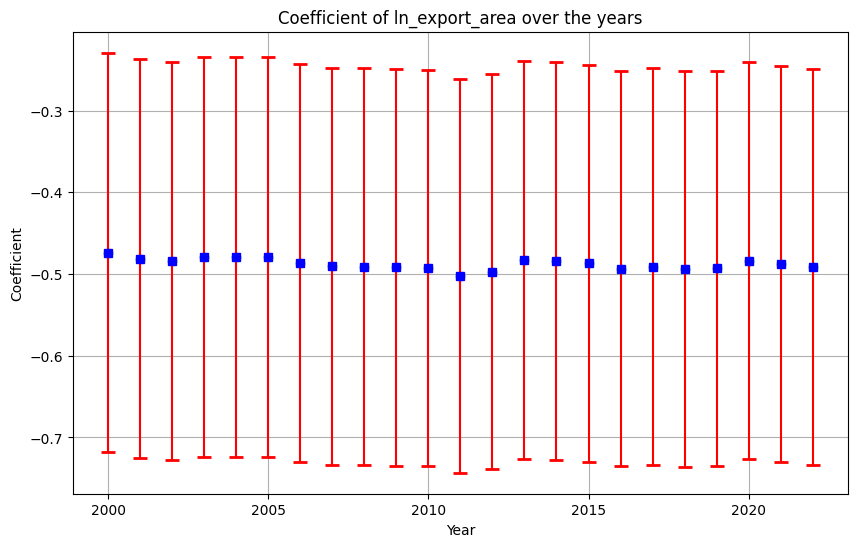

In [204]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

# Plot coefficients for each dependent variable
plt.scatter(coefficients_df['Year'], coefficients_df['Coefficient'])
plt.errorbar(coefficients_df['Year'], coefficients_df['Coefficient'], 
             yerr=[coefficients_df['Coefficient'] - coefficients_df['Lower CI'],
                   coefficients_df['Upper CI'] - coefficients_df['Coefficient']],
             fmt='o', capsize=5, capthick=2, ecolor='red', marker='s', color='blue',
             label='Coefficient with 95% CI')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Coefficient of ln_export_area over the years')
plt.grid(True)

# Show plot
plt.show()

## **Comparing the Results of the Lasso Regression With the Results of the Replication** ##

### **Step 1: Bring in the results of the replication** ###
The following code was brought over directly from the replication file to create an aggregate plot. In this code, the models are created with the specifications defined in the paper, and the resulting coefficients of each model are then stored for plotting.

In [205]:
df = pd.read_csv('slave_trade_QJE_New_Data.csv')

second_stage_variables = ['gdp00', 'gpd01', 'gdp02', 'gdp03', 'gdp04', 'gdp05', 'gdp06', 'gdp07', 'gdp08', 'gdp09', 'gdp10', 'gdp11', 'gdp12', 'gdp13', 'gdp14', 'gdp15','gdp16', 'gdp17', 'gdp18', 'gdp19', 'gdp20', 'gdp21', 'gdp22']

for dependent_variable in second_stage_variables:
    # Step 1: First Stage Regression
    # Define the endogenous variable (to be instrumented) and the instrument
    endog_first_stage = df['ln_export_area']
    instrument_first_stage = df[['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum',
                                 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                                 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

    # Add constant to the instrument
    instrument_first_stage = sm.add_constant(instrument_first_stage)

    # Fit the first stage regression
    first_stage_model = sm.OLS(endog_first_stage, instrument_first_stage).fit()

    # Step 2: Predicted Values from First Stage
    # Get the predicted values from the first stage
    df['ln_export_area_predicted'] = first_stage_model.predict()
    
    # Step 3: Second Stage Regression
    # Define the exogenous variable (including the predicted values from the first stage)
    exog_second_stage = df[['ln_export_area_predicted', 'colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',
                            'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']]

    # Add constant to the exogenous variables
    exog_second_stage = sm.add_constant(exog_second_stage)

    # Fit the second stage regression
    second_stage_model = sm.OLS(df[dependent_variable], exog_second_stage).fit()
    
coefficients_table2 = []

for dependent_variable in second_stage_variables:
    # Rest of the code remains the same as before

    # Fit the second stage regression
    second_stage_model = sm.OLS(df[dependent_variable], exog_second_stage).fit()

    # Extract the coefficient of ln_export_area_predicted
    coefficient2 = second_stage_model.params['ln_export_area_predicted']

    # Extract the standard error of ln_export_area_predicted
    std_err2 = second_stage_model.bse['ln_export_area_predicted']
    # Calculate the 95% confidence intervals
    lower_ci2 = coefficient2 - 1.96 * std_err2
    upper_ci2 = coefficient2 + 1.96 * std_err2

    # Store the coefficient along with the dependent variable name
    coefficients_table2.append({'Dependent Variable': dependent_variable, 'Coefficient': coefficient2, 'Lower CI': lower_ci2, 'Upper CI': upper_ci2})

# Create a DataFrame from the coefficients list
coefficients2_df = pd.DataFrame(coefficients_table2)

# Add a column representing years from 2000 to 2022
years = list(range(2000, 2023))
coefficients2_df['Year'] = years

# Print the coefficients table
print(coefficients2_df)

   Dependent Variable  Coefficient  Lower CI  Upper CI  Year
0               gdp00    -0.417695 -0.639112 -0.196277  2000
1               gpd01    -0.409542 -0.630617 -0.188466  2001
2               gdp02    -0.413216 -0.635245 -0.191188  2002
3               gdp03    -0.393435 -0.612257 -0.174613  2003
4               gdp04    -0.380955 -0.600302 -0.161608  2004
5               gdp05    -0.377960 -0.601276 -0.154645  2005
6               gdp06    -0.380701 -0.605394 -0.156009  2006
7               gdp07    -0.388052 -0.613707 -0.162397  2007
8               gdp08    -0.380723 -0.605096 -0.156351  2008
9               gdp09    -0.376195 -0.597078 -0.155311  2009
10              gdp10    -0.370007 -0.593259 -0.146756  2010
11              gdp11    -0.377192 -0.602801 -0.151583  2011
12              gdp12    -0.372040 -0.597876 -0.146204  2012
13              gdp13    -0.357059 -0.587457 -0.126660  2013
14              gdp14    -0.353198 -0.585189 -0.121207  2014
15              gdp15   

### **Step 2: Modeling the results of the replication and lasso together** ###
Finally, we plot the results of the models from the replication and the lasso implementation together for a visual comparison of the results. As we can see, the results of the lasso regression tend to be more negative, but the standard error is much higher, leading to non-statistically significant results.

C:\Users\Davis\AppData\Local\Temp\ipykernel_2396\1667156179.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(coefficients2_df['Year'], coefficients2_df['Coefficient'],
C:\Users\Davis\AppData\Local\Temp\ipykernel_2396\1667156179.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(coefficients_df['Year'], coefficients_df['Coefficient'],


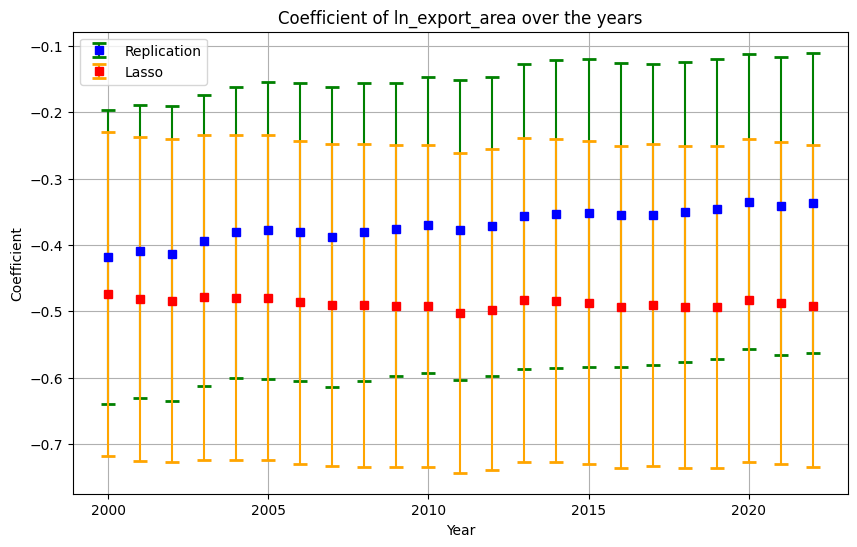

In [207]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot coefficients for each dependent variable
plt.errorbar(coefficients2_df['Year'], coefficients2_df['Coefficient'], 
             yerr=[coefficients2_df['Coefficient'] - coefficients2_df['Lower CI'],
                   coefficients2_df['Upper CI'] - coefficients2_df['Coefficient']],
             fmt='o', capsize=5, capthick=2, ecolor='green', marker='s', color='blue',
             label='Replication')
plt.errorbar(coefficients_df['Year'], coefficients_df['Coefficient'], 
             yerr=[coefficients_df['Coefficient'] - coefficients_df['Lower CI'],
                   coefficients_df['Upper CI'] - coefficients_df['Coefficient']],
             fmt='o', capsize=5, capthick=2, ecolor='orange', marker='s', color='red',
             label='Lasso')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Coefficient')
plt.title('Coefficient of ln_export_area over the years')
plt.grid(True)
plt.legend() 

# Show plot
plt.show()
     